# Imports

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression

import numpy as np 


import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', None)

sns.color_palette("coolwarm", n_colors=8)
blue_palette = sns.color_palette(["#003f5c", "#2f4b7c", "#665191", "#a05195", "#d45087", "#f95d6a", "#ff7c43", "#ffa600"])
sns.set_palette(blue_palette)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=blue_palette.as_hex())

# Functions

## Data Quality

In [30]:
def consistent_id(df: pd.DataFrame, column: str) -> bool:
    """
    Verifica se a coluna fornecida contém valores únicos para cada linha,
    garantindo a consistência de IDs exclusivos.

    Parâmetros:
    - df: pd.DataFrame - DataFrame contendo a coluna a ser verificada.
    - column: str - Nome da coluna a ser verificada.

    Retorno:
    - bool - Retorna True se a coluna contém valores únicos, caso contrário, False.
    """
    return df[column].nunique() == df.shape[0]

# Qualidade
def missing_verify(df: pd.DataFrame) -> pd.DataFrame:
    """
    Verifica a presença de valores nulos em um DataFrame e retorna um resumo.

    Parâmetros:
    - df: pd.DataFrame - DataFrame a ser verificado.

    Retorno:
    - pd.DataFrame - DataFrame contendo as contagens e porcentagens de valores nulos por coluna.
    """
    null_counts = df.isnull().sum()
    null_percentage = (null_counts / len(df)) * 100
    columns_with_nulls = null_counts[null_counts > 0].index.tolist()
    
    if columns_with_nulls:
        print("Colunas que contêm valores nulos:", columns_with_nulls)
    else:
        print("Nenhuma coluna contém valores nulos.")
    
    null_df = pd.DataFrame({
        'null': null_counts,
        'percentage': null_percentage
    })
    
    return null_df

def missing_input_by(df: pd.DataFrame, column: str, method: str) -> pd.DataFrame:
    """
    Imputa valores ausentes em uma coluna com base no método especificado.

    Parâmetros:
    - df: pd.DataFrame - DataFrame com a coluna a ser imputada.
    - column: str - Nome da coluna onde os valores ausentes serão imputados.
    - method: str - Método de imputação ('constant', 'mean', 'median', 'mode', 'interpolate', 'knn', 'regression').

    Retorno:
    - pd.DataFrame - DataFrame com a coluna imputada.
    """
    if method == 'constant':
        df[column].fillna(0, inplace=True)

    elif method == 'mean':
        df[column].fillna(df[column].mean(), inplace=True)

    elif method == 'median':
        df[column].fillna(df[column].median(), inplace=True)

    elif method == 'mode':
        df[column].fillna(df[column].mode()[0], inplace=True)

    elif method == 'interpolate':
        df[column].interpolate(method='linear', inplace=True)

    elif method == 'knn':
        imputer = KNNImputer(n_neighbors=5)
        df[[column]] = imputer.fit_transform(df[[column]])

    elif method == 'regression':
        other_columns = df.columns.difference([column])
        non_null_df = df.dropna(subset=[column])
        
        model = LinearRegression()
        model.fit(non_null_df[other_columns], non_null_df[column])
        
        missing_df = df[df[column].isnull()]
        df.loc[df[column].isnull(), column] = model.predict(missing_df[other_columns])

    return df

def replace_outliers(df: pd.DataFrame, col: str, method: str) -> pd.Series:
    """
    Substitui os outliers em uma coluna com base no método especificado (média, mediana ou moda).

    Parâmetros:
    - df: pd.DataFrame - DataFrame contendo os dados.
    - col: str - Nome da coluna a ser processada.
    - method: str - Método de substituição dos outliers ('mean', 'median' ou 'mode').

    Retorna:
    - pd.Series - Série da coluna processada com os outliers substituídos.
    """
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75) 
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Definir o valor de substituição
    if method == 'mean':
        replacement_value = df[col].mean()
    elif method == 'median':
        replacement_value = df[col].median()
    elif method == 'mode':
        replacement_value = df[col].mode()[0]
    else:
        raise ValueError("Method must be 'mean', 'median', or 'mode'.")
    
    # Substituir os outliers
    df[col] = df[col].apply(lambda x: replacement_value if x < lower_bound or x > upper_bound else x)
    
    return df[col]

## DataViz

In [31]:
def get_palette_from_json(states, colors_json) -> list:
    """
    Retorna uma lista de cores primárias correspondentes aos estados fornecidos.

    Parâmetros:
    - states: list - Lista de estados.
    - colors_json: dict - Dicionário contendo as cores primárias por estado.

    Retorno:
    - list - Lista de cores primárias.
    """
    return [colors_json[state]['primary_color'] for state in states]


def plot_bar_simple(df: pd.DataFrame, col: str, plot_config: dict, orientation='vertical'):
    """
    Plota um gráfico de barras simples para a coluna especificada do DataFrame.

    Parâmetros:
    - df (pd.DataFrame): DataFrame contendo os dados.
    - col (str): Nome da coluna para análise.
    - plot_config (dict): Configurações do gráfico, incluindo opções como 'figsize', 'title', 'x_label', 'y_label', 'axis_font_size', 'title_size', e 'color'.
    - orientation (str): Orientação do gráfico de barras, 'vertical' ou 'horizontal'.

    Retorno:
    - None
    """
    plt.figure(figsize=plot_config.get('figsize', (8, 6)))
    
    # Plotar o gráfico de barras
    if orientation == 'horizontal':
        sns.barplot(y=df[col].value_counts().index, x=df[col].value_counts().values)
    else:
        sns.barplot(x=df[col].value_counts().index, y=df[col].value_counts().values)

    # Ajustar título e rótulos
    plt.title(plot_config.get('title', ''), fontsize=plot_config.get('title_size', 16))
    plt.xlabel(plot_config.get('x_label', 'Contagem'), fontsize=plot_config.get('axis_font_size', 12))
    plt.ylabel(plot_config.get('y_label', col), fontsize=plot_config.get('axis_font_size', 12))
    
    plt.tight_layout()
    plt.show()


def plot_bar_grouped(df: pd.DataFrame, col: str, grouped: str, plot_config: dict, orientation='vertical') -> None:
    """
    Plota um gráfico de barras agrupadas para a coluna especificada do DataFrame, agrupado por outra coluna,
    com opção de orientação.

    Parâmetros:
    - df (pd.DataFrame): DataFrame contendo os dados.
    - col (str): Nome da coluna para análise.
    - grouped (str): Nome da coluna para agrupamento.
    - plot_config (dict): Configurações do gráfico, incluindo 'figsize', 'title', 'x_label', 'y_label', 
                          'axis_font_size', 'title_size', e 'colors'.
    - orientation (str): Orientação do gráfico de barras, 'vertical' ou 'horizontal'.

    Retorno:
    - None
    """
    plt.figure(figsize=plot_config.get('figsize', (8, 6)))

    palette = plot_config.get('colors', None)
    
    if orientation == 'vertical':
        sns.barplot(data=df, y=grouped, x=col, hue=grouped, palette=palette)
        plt.xlabel(plot_config.get('x_label', col), fontsize=plot_config.get('axis_font_size', 12))
        plt.ylabel(plot_config.get('y_label', grouped), fontsize=plot_config.get('axis_font_size', 12))
    else:
        sns.barplot(data=df, x=grouped, y=col, hue=grouped, palette=palette)
        plt.xlabel(plot_config.get('x_label', grouped), fontsize=plot_config.get('axis_font_size', 12))
        plt.ylabel(plot_config.get('y_label', col), fontsize=plot_config.get('axis_font_size', 12))

 
    plt.axhline(0, color='black', linewidth=1.3)  
    plt.ylim(bottom=0)
    plt.title(plot_config.get('title', ''), fontsize=plot_config.get('title_size', 16))
    
    plt.tight_layout()
    plt.show()
   
def plot_boxplot_grouped(df: pd.DataFrame, col: str, grouped: str, plot_config: dict, orientation: str = 'vertical') -> None:
    """
    Plota um boxplot agrupado por uma coluna de agrupamento, com a opção de orientação.

    Parâmetros:
    - df: pd.DataFrame - DataFrame contendo os dados.
    - col: str - Nome da coluna a ser plotada.
    - grouped: str - Nome da coluna de agrupamento.
    - plot_config: dict - Dicionário contendo configurações do plot (cores, título, etc.).
    - orientation: str - Orientação do boxplot ('vertical' ou 'horizontal').
    
    Retorno:
    - None
    """
    unique_group = df[grouped].unique()
    
    plt.figure(figsize=plot_config.get('figsize', (8, 6)))
    
    if 'colors' in plot_config:
        palette = get_palette_from_json(unique_group, plot_config['colors'])
    else:
        palette = None


    if orientation == 'horizontal':
        sns.boxplot(data=df, y=grouped, x=col, palette=palette)
        plt.xlabel(plot_config.get('x_label', col), fontsize=plot_config.get('axis_font_size', 12))
        plt.ylabel(plot_config.get('y_label', grouped), fontsize=plot_config.get('axis_font_size', 12))
    else:
        sns.boxplot(data=df, x=grouped, y=col, palette=palette)
        plt.xlabel(plot_config.get('x_label', grouped), fontsize=plot_config.get('axis_font_size', 12))
        plt.ylabel(plot_config.get('y_label', col), fontsize=plot_config.get('axis_font_size', 12))
    
    plt.title(plot_config.get('title', ''), fontsize=plot_config.get('title_size', 16))
    
    plt.show()


def plot_boxplot_simple(df: pd.DataFrame, col: str, plot_config: dict, orientation=False) -> None:
    """
    Plota um boxplot para uma coluna especificada do DataFrame.

    Parâmetros:
    - df: pd.DataFrame - DataFrame contendo os dados.
    - col: str - Nome da coluna a ser plotada.
    - plot_config: dict - Dicionário contendo configurações do plot (tamanho, cor, título, etc.).
    - orientation: bool - Se True, plota o boxplot verticalmente, caso contrário, horizontalmente.
    
    Retorno:
    - None
    """
    plt.figure(figsize=plot_config.get('figsize', (8, 6)))
    
    if orientation:
        sns.boxplot(y=df[col])
    else: 
        sns.boxplot(x=df[col])

    plt.title(plot_config.get('title', ''), fontsize=plot_config.get('title_size', 16))
    plt.xlabel(plot_config.get('x_label', col), fontsize=plot_config.get('axis_font_size', 12))
    plt.ylabel(plot_config.get('y_label', ''), fontsize=plot_config.get('axis_font_size', 12))
    
    plt.tight_layout()
    plt.show()

def plot_displot_simple(df: pd.DataFrame, col: str, plot_config: dict) -> None:
    """
    Plota um gráfico de densidade simples (KDE) para uma coluna.

    Parâmetros:
    - df: pd.DataFrame - DataFrame contendo os dados.
    - col: str - Nome da coluna a ser plotada.
    - plot_config: dict - Dicionário contendo configurações do plot (título, rótulos, etc.).

    Retorno:
    - None
    """
    height = plot_config.get('figsize', (8, 6))[1]  # altura da figura
    aspect = plot_config.get('figsize', (8, 6))[0] / height  # relação de aspecto

    sns.displot(df, x=col, kind="kde", palette="tab20", height=height, aspect=aspect, fill=False)
    
    plt.title(plot_config.get('title', ''), fontsize=plot_config.get('title_size', 16))
    plt.xlabel(plot_config.get('x_label', col), fontsize=plot_config.get('axis_font_size', 12))
    plt.ylabel(plot_config.get('y_label', 'Densidade'), fontsize=plot_config.get('axis_font_size', 12))

    plt.show()

def plot_displot_grouped(df: pd.DataFrame, col: str, grouped: str, plot_config: dict) -> None:
    """
    Plota um gráfico de densidade (KDE) agrupado por uma coluna específica.

    Parâmetros:
    - df: pd.DataFrame - DataFrame contendo os dados.
    - col: str - Nome da coluna a ser plotada.
    - grouped: str - Nome da coluna de agrupamento.
    - plot_config: dict - Dicionário contendo configurações do plot (título, rótulos, etc.).

    Retorno:
    - None
    """
    plt.figure(figsize=plot_config.get('figsize', (8, 6)))

    sns.displot(df, x=col, hue=grouped, kind="kde", palette="tab20", height=8, aspect=1.5, fill=False)

    plt.title(plot_config.get('title', ''), fontsize=plot_config.get('title_size', 16))
    plt.xlabel(plot_config.get('x_label', col), fontsize=plot_config.get('axis_font_size', 12))
    plt.ylabel(plot_config.get('y_label', 'Densidade'), fontsize=plot_config.get('axis_font_size', 12))

    plt.show()

def plot_displot_with_stats(df: pd.DataFrame, col: str, plot_config: dict) -> None:
    """
    Plota um gráfico de densidade (KDE) com linhas representando média, mediana e moda.

    Parâmetros:
    - df: pd.DataFrame - DataFrame contendo os dados.
    - col: str - Nome da coluna a ser plotada.
    - plot_config: dict - Dicionário contendo configurações do plot (título, rótulos, etc.).

    Retorno:
    - None
    """
    mean_value = df[col].mean()
    median_value = df[col].median()
    mode_value = df[col].mode()[0]

    plt.figure(figsize=plot_config.get('figsize', (8, 6)))
    sns.kdeplot(df[col], fill=False, palette="tab20")

    plt.axvline(mean_value, color='red', linestyle='--', label=f'Média: {mean_value:.2f}')
    plt.axvline(median_value, color='blue', linestyle='-', label=f'Mediana: {median_value:.2f}')
    plt.axvline(mode_value, color='green', linestyle='-.', label=f'Moda: {mode_value:.2f}')

    plt.title(plot_config.get('title', ''), fontsize=plot_config.get('title_size', 16))
    plt.xlabel(plot_config.get('x_label', col), fontsize=plot_config.get('axis_font_size', 12))
    plt.ylabel(plot_config.get('y_label', 'Densidade'), fontsize=plot_config.get('axis_font_size', 12))

    plt.legend()
    plt.show()

def plot_filtered_correlation_matrix(df, criteria):
    
    """
    Plota uma matriz de correlação filtrada com base em critérios específicos.
    
    Parâmetros:
    df (pd.DataFrame): O DataFrame contendo os dados.
    criteria (str): O critério para filtrar as correlações a serem exibidas. Pode ser:
                    - 'positive' para correlações positivas (fortes, moderadas ou fracas),
                    - 'negative' para correlações negativas,
                    - 'neutral' para correlações próximas de zero.
    """
    
    corr_matrix = df.corr()
    
    if criteria == 'positive':
        print('Filtrando Correlações Positivas')
        mask = (corr_matrix >= 0.5) & (abs(corr_matrix) != 1.0)
    elif criteria == 'negative':
        print('Filtrando Correlações Negativas')
        mask = (corr_matrix <= -0.5) & (abs(corr_matrix) != 1.0)
    elif criteria == 'neutral':
        print('Filtrando Correlações Neutras')
        mask = (abs(corr_matrix) < 0.1) & (abs(corr_matrix) != 1.0)
    else:
        raise ValueError("Critério inválido. Use 'positive', 'negative' ou 'neutral'.")
 
    mask_np = mask.to_numpy()
    
    if not mask_np.any():
        print('Não possui Correlação Válida')
        return
      
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, mask=~mask, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
    plt.title(f'Matriz de Correlação Filtrada ({criteria.capitalize()})')
    plt.show()

def plot_histogram(data: pd.DataFrame, col: str, plot_config: dict) -> None:
    """
    Plota um histograma de uma coluna especificada.

    Parâmetros:
    - data: pd.DataFrame - DataFrame contendo os dados.
    - col: str - Nome da coluna a ser plotada.
    - plot_config: dict - Dicionário contendo configurações do plot (título, rótulos, etc.).

    Retorno:
    - None
    """
    plt.figure(figsize=plot_config.get('figsize', (8, 6)))

    sns.histplot(data[col], bins=30, kde=False)

    plt.title(plot_config.get('title', ''), fontsize=plot_config.get('title_size', 16))
    plt.xlabel(plot_config.get('x_label', 'Valor'), fontsize=plot_config.get('axis_font_size', 12))
    plt.ylabel(plot_config.get('y_label', 'Frequência'), fontsize=plot_config.get('axis_font_size', 12))
    
    plt.tight_layout()
    plt.show()

def plot_pie_chart(df: pd.DataFrame, col: str, plot_config: dict) -> None:
    """
    Plota um gráfico de pizza para a coluna especificada do DataFrame.

    Parâmetros:
    - df (pd.DataFrame): DataFrame contendo os dados.
    - col (str): Nome da coluna para análise.
    - plot_config (dict): Configurações do gráfico, incluindo 'figsize', 'title', 'colors'.

    Retorno:
    - None
    """
  
    data = df[col].value_counts()
    labels = data.index
    sizes = data.values

    plt.figure(figsize=plot_config.get('figsize', (8, 6)))

    colors = plot_config.get('colors', None)

    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, 
            textprops={'fontsize': plot_config.get('text_size', 12)}, 
            wedgeprops={'edgecolor': 'black'})


    plt.title(plot_config.get('title', ''), fontsize=plot_config.get('title_size', 16))

    plt.tight_layout()
    plt.show()


def plot_scatter_with_regression(df, target, columns):
    """
    Plota gráficos de dispersão entre um conjunto de colunas e a variável alvo, com uma linha de regressão.
    Máximo de 3 gráficos por linha.
    
    Parâmetros:
    df (pd.DataFrame): O DataFrame contendo os dados.
    target (str): O nome da variável alvo para a qual a regressão será calculada.
    columns (list of str): Lista de nomes das colunas para as quais os gráficos de dispersão serão criados.
    """
    if target not in df.columns:
        raise ValueError(f"A variável alvo '{target}' não está presente no DataFrame.")
    
    for column in columns:
        if column not in df.columns:
            raise ValueError(f"A coluna '{column}' não está presente no DataFrame.")

    max_cols = 3
    num_plots = len(columns)
    num_rows = int(np.ceil(num_plots / max_cols))  
    
    # Cria a figura e os subplots
    plt.figure(figsize=(6 * max_cols, 6 * num_rows))
    
    for i, column in enumerate(columns):
        plt.subplot(num_rows, max_cols, i + 1)
        sns.regplot(x=column, y=target, data=df, scatter_kws={'s':30}, line_kws={'color':'red'})
        plt.title(f'{column} vs {target}')
        plt.xlabel(column)
        plt.ylabel(target)
    
    plt.tight_layout()
    plt.show()
    
    plt.tight_layout()
    plt.show()

## Stats

In [32]:
def extended_stats_by_group(df: pd.DataFrame, group_col: str, value_col: str) -> pd.DataFrame:
    """
    Calcula estatísticas detalhadas para uma coluna de valores, agrupado por uma coluna de grupo.

    Parâmetros:
    - df: pd.DataFrame - DataFrame contendo os dados.
    - group_col: str - Nome da coluna para agrupamento.
    - value_col: str - Nome da coluna para análise estatística.

    Retorna:
    - pd.DataFrame - DataFrame com contagem, porcentagem, valor máximo, valor mínimo, média, mediana, desvio padrão,
                     assimetria, intervalo interquartílico (IQR) e coeficiente de variação (CV) para cada grupo.
    """
    counts = df[group_col].value_counts()
    percentages = df[group_col].value_counts(normalize=True) * 100

    stats = df.groupby(group_col)[value_col].agg(['count', 'min', 'max', 'mean', 'median', 'std', 'skew'])
    
   
    stats['IQR'] = df.groupby(group_col)[value_col].apply(lambda x: x.quantile(0.75) - x.quantile(0.25))
    
    stats['Percentage'] = percentages
    stats['CV'] = stats['std'] / stats['mean'] * 100

    stats.rename(columns={'count': 'Count', 'min': 'Min', 'max': 'Max', 'mean': 'Mean', 'median': 'Median', 
                          'std': 'StdDev', 'skew': 'Skewness', 'CV': 'CoefVar'}, inplace=True)
    
    return stats.reset_index()

def get_correlations_with_target(df, target, criteria):
    """
    Retorna as variáveis que possuem correlação com a variável alvo de acordo com o critério especificado.
    
    Parâmetros:
    df (pd.DataFrame): O DataFrame contendo os dados.
    target (str): O nome da variável alvo com a qual as correlações devem ser verificadas.
    criteria (str): O critério para filtrar as correlações. Pode ser:
                    - 'positive' para correlações positivas,
                    - 'negative' para correlações negativas,
                    - 'neutral' para correlações próximas de zero (abaixo de 0.1).
    
    Retorna:
    pd.Series: Uma série com as variáveis e suas correlações com a variável alvo de acordo com o critério especificado.
    """
    if target not in df.columns:
        raise ValueError(f"A variável alvo '{target}' não está presente no DataFrame.")
    
    corr_matrix = df.corr()
    
    target_corr = corr_matrix[target]
    
    if criteria == 'positive':
        filtered_corr = target_corr[target_corr > 0].drop(target, errors='ignore')
    elif criteria == 'negative':
        filtered_corr = target_corr[target_corr < 0].drop(target, errors='ignore')
    elif criteria == 'neutral':
        filtered_corr = target_corr[(abs(target_corr) < 0.1) & (abs(target_corr) != 0)].drop(target, errors='ignore')
    else:
        raise ValueError("Critério inválido. Use 'positive', 'negative' ou 'neutral'.")
    
    return filtered_corr

def value_counts_with_percentage(df: pd.DataFrame, col: str) -> pd.DataFrame:
    """
    Conta os valores únicos e calcula a porcentagem de cada valor na coluna especificada do DataFrame.
    
    Parâmetros:
    - df: pd.DataFrame - DataFrame contendo os dados.
    - col: str - Nome da coluna a ser analisada.
    
    Retorna:
    - pd.DataFrame - DataFrame com contagem e porcentagem dos valores únicos na coluna.
    """
    counts = df[col].value_counts()
    percentages = df[col].value_counts(normalize=True) * 100
    
    result = pd.DataFrame({
        'Count': counts,
        'Percentage': percentages
    })
    
    return result


# Load Data

In [33]:
df = pd.read_excel(r"../datasets/dados_credito.xlsx")
df.head()

,CODIGO_CLIENTE,UF,IDADE,ESCOLARIDADE,ESTADO_CIVIL,QT_FILHOS,CASA_PROPRIA,QT_IMOVEIS,VL_IMOVEIS,OUTRA_RENDA,OUTRA_RENDA_VALOR,TEMPO_ULTIMO_EMPREGO_MESES,TRABALHANDO_ATUALMENTE,ULTIMO_SALARIO,QT_CARROS,VALOR_TABELA_CARROS,SCORE
0,1,SP,19,Superior Cursando,Solteiro,0,Não,0,0,Não,0,8,Sim,1800,0,0,12.00
1,2,MG,23,Superior Completo,Solteiro,1,Não,0,0,Não,0,9,Não,4800,1,50000,18.00
2,3,SC,25,Segundo Grau Completo,Casado,0,Sim,1,220000,Não,0,18,Sim,2200,2,30000,23.00
3,4,PR,27,Superior Cursando,Casado,1,Sim,0,0,Não,0,22,Não,3900,0,0,28.67
4,5,RJ,28,Superior Completo,Divorciado,2,Não,1,370000,Não,0,30,Sim,NaN,1,35000,34.17


## Credit scores ranges


O _credit score_ é um número que representa a capacidade de um cliente em honrar suas dívidas. Esse índice é fundamental para instituições financeiras, pois auxilia na avaliação do risco de crédito de um cliente. Uma pontuação alta geralmente indica uma boa saúde financeira e a capacidade de pagar empréstimos, enquanto uma pontuação baixa pode indicar dificuldades financeiras.

Áreas de Atuação do Credit Score

* Avaliação de Risco

As instituições financeiras utilizam o credit score para determinar a probabilidade de um cliente não pagar um empréstimo. Isso ajuda a decidir se devem conceder crédito e quais condições aplicar.

* Taxas de Juros

Clientes com scores mais altos tendem a receber taxas de juros mais baixas, refletindo a menor percepção de risco. Em contrapartida, aqueles com scores baixos podem enfrentar juros mais altos ou até mesmo a recusa de crédito.

* Condições de Crédito

Além das taxas de juros, o score influencia o montante do crédito disponível e as condições de pagamento.
Separar os clientes com base em seus scores é importante para a tomada de decisões estratégicas em relação ao crédito. Essa segmentação permite que as instituições identifiquem quais clientes representam menor risco e quais precisam de atenção especial.

De acordo com a FICO Scores, uma das principais empresas que desenvolve modelos de pontuação de crédito, a classificação costuma ser feita da seguinte maneira:

    Excelente: 781 - 850
    Bom: 661 - 780
    Justo: 601 - 660
    Ruim: 500 - 600
    Muito Ruim: 300 - 499

<div align="center">
    <img src="https://www.credit.com/blog/wp-content/uploads/2023/12/fico-credit-score-ranges.webp" alt="Descrição da imagem" width="400" height="auto" />
    <p><a href="https://www.experian.com/blogs/ask-experian/credit-education/score-basics/what-is-a-good-credit-score/">Clique para referência</a></p>
</div>


## Credit Range Score

Para classificar os scores de crédito dos clientes existem diversas técnicas e abordagens. Cada uma será utilizada de acordo com os objetivos de nogócio e padrão de dados. Algumas técnicas comuns são:

* **Definição de Limites (_Thresholding_)**

     Essa tecnica consiste em estabelecer limites numéricos para cada categoria.

     Essas categorias podem seguir as definidas pela FICO, por exemplo, ou pelas regras de negócio, suponha:

     * Bom: scores acima de 700

     * Médio: scores entre 600 e 700
     
     * Ruim: scores abaixo de 600


* **Discretização**

     A técnica de discretização, também pode ser utilizada nesses aspectos, uma vez que é utilizada para converter scores contínuos em categorias discretas. 

     Os métodos incluem:

     * Equal Width Binning: Divide o intervalo dos scores em bins (faixas) de largura igual.
     * Equal Frequency Binning: Divide os dados de forma que cada bin tenha o mesmo número de observações.

* **Aprendizado de Máquina - Classificação**

     Também é possivel utilizar alguns algoritmos de aprendizado de máquina para classificar scores de crédito.

     Os algoritmos incluem:

     * Regressão Logística
     * Árvore de Decisão
     * Random Forest
     * SVM (Máquinas de Vetores de Suporte)

* **Aprendizado de Máquina Clusterização**

     A técnica de análise de clustering consiste em agrupar os dados por características em comum. Geralmente delimita-se uma quantidade de grupos que deseja-se extrais daquela base de dados. Os algoritimos agrupam os dados baseadas em similaridade entre os dados ou entre os grupos. 

     Os algoritimos incluem:

     * k-means
     * knn
______________________________________________________________________________________________________________________________________
> [!NOTE]

> Neste projeto será utilizado o padrão FICO.


In [34]:
df['SCORE'].describe()

count   10476.00
mean       51.06
std        27.31
min        12.00
25%        28.67
50%        45.17
75%        72.67
max        98.00
Name: SCORE, dtype: float64

In [35]:
def scale_scores(df, column, new_min=100, new_max=1000):
    """
    Transforma os valores da coluna especificada de um DataFrame para um novo intervalo.

    Parâmetros:
    - df: DataFrame contendo a coluna de scores.
    - column: Nome da coluna contendo os valores de score a serem transformados.
    - new_min: Valor mínimo do novo intervalo (default = 100).
    - new_max: Valor máximo do novo intervalo (default = 1000).

    Retorna:
    - Uma nova coluna com os valores escalados.
    """

    old_min = df[column].min()
    old_max = df[column].max()
    
    df[f'{column}_scaled'] = ((df[column] - old_min) / (old_max - old_min)) * (new_min - new_max) + new_max
    
    return df

def classify_score(score):
    if score >= 781 and score <= 850:
        return 'Exeptional'
    elif score >= 661 and score <= 780:
        return 'Very Good'
    elif score >= 601 and score <= 660:
        return 'Good'
    elif score >= 500 and score <= 600:
        return 'Fair'
    elif score >= 300 and score <= 499:
        return 'Poor'
    else:
        return 'Invalid Score'

In [36]:
df = scale_scores(df, 'SCORE', new_min=300, new_max=850)
df['SCORE_classification'] = df['SCORE_scaled'].apply(lambda score: classify_score(score))
df['SCORE_scaled'].describe()

count   10476.00
mean      600.21
std       174.63
min       300.00
25%       462.02
50%       637.89
75%       743.41
max       850.00
Name: SCORE_scaled, dtype: float64

In [37]:
df['SCORE_classification'].value_counts()

SCORE_classification
Poor          3654
Very Good     3168
Exeptional    1638
Good          1080
Fair           936
Name: count, dtype: int64

# Exploratory Data Analysis

In [38]:
print("Os códigos dos clientes estão consistentes? Isto é, há ids únicos para cada cliente?: ", consistent_id( df, 'CODIGO_CLIENTE'))
missing_verify(df)

Os códigos dos clientes estão consistentes? Isto é, há ids únicos para cada cliente?:  True
Colunas que contêm valores nulos: ['ULTIMO_SALARIO']


,null,percentage
CODIGO_CLIENTE,0,0.00
UF,0,0.00
IDADE,0,0.00
ESCOLARIDADE,0,0.00
ESTADO_CIVIL,0,0.00
QT_FILHOS,0,0.00
CASA_PROPRIA,0,0.00
QT_IMOVEIS,0,0.00
VL_IMOVEIS,0,0.00
OUTRA_RENDA,0,0.00


## Missing Values

Para lidar com valores faltantes, diversas técnicas podem ser aplicadas. A escolha da técnica mais adequada dependerá da análise da distribuição dos dados da variável 'ÚLTIMO_SALÁRIO'.

A seguir, apresentamos algumas abordagens comuns e quando utilizá-las:

 * Média: Adequada para dados que seguem uma distribuição simétrica e não possuem outliers significativos. Essa técnica é útil para manter a consistência na média dos dados e é eficaz quando os valores ausentes são relativamente poucos.

* Mediana: Recomendada para distribuições assimétricas ou quando existem outliers. A mediana proporciona uma medida central mais robusta e menos afetada por valores extremos.

* Moda: Ideal para dados categóricos ou distribuições multimodais, onde há uma ou mais categorias que ocorrem com maior frequência. A moda é útil para preservar a frequência das categorias predominantes.

A decisão sobre qual técnica utilizar deve ser baseada na análise detalhada da distribuição dos dados e na natureza dos valores ausentes. Aplicar a técnica adequada garantirá a integridade e a precisão dos dados imputados.

In [39]:
df[df['ULTIMO_SALARIO'].isnull() == True]

,CODIGO_CLIENTE,UF,IDADE,ESCOLARIDADE,ESTADO_CIVIL,QT_FILHOS,CASA_PROPRIA,QT_IMOVEIS,VL_IMOVEIS,OUTRA_RENDA,OUTRA_RENDA_VALOR,TEMPO_ULTIMO_EMPREGO_MESES,TRABALHANDO_ATUALMENTE,ULTIMO_SALARIO,QT_CARROS,VALOR_TABELA_CARROS,SCORE,SCORE_scaled,SCORE_classification
4,5,RJ,28,Superior Completo,Divorciado,2,Não,1,370000,Não,0,30,Sim,NaN,1,35000,34.17,708.24,Very Good
10474,10475,RJ,48,Superior Completo,Divorciado,2,Não,1,370000,Não,0,30,Sim,NaN,1,35000,34.17,708.24,Very Good


Mesmo que os valores faltantes sejam representados como None, a característica dos dados deveria ser numérica. Portanto, ao examinar a descrição estatística dos dados, podemos observar que há valores categóricos que precisam ser tratados adequadamente.

É importante revisar a distribuição e o tipo de dados apresentados para garantir que todos os valores sejam consistentes com o tipo de variável esperado. A presença de valores categóricos em uma coluna esperada como numérica sugere a necessidade de um tratamento adicional para alinhar os dados à sua estrutura correta e garantir a precisão das análises subsequentes.

Após a análise, identificou-se que o valor de referência para os dados categóricos é 'SEM DADOS'. Esse valor deve ser utilizado para substituir ou tratar entradas que não possuem informação específica, garantindo que a integridade dos dados seja mantida e que a análise subsequente reflita corretamente as ausências de informação.

In [40]:
df['ULTIMO_SALARIO'].describe()

count     10474
unique       18
top        1800
freq        846
Name: ULTIMO_SALARIO, dtype: int64

In [41]:
df[df['ULTIMO_SALARIO'] == 'SEM DADOS']

,CODIGO_CLIENTE,UF,IDADE,ESCOLARIDADE,ESTADO_CIVIL,QT_FILHOS,CASA_PROPRIA,QT_IMOVEIS,VL_IMOVEIS,OUTRA_RENDA,OUTRA_RENDA_VALOR,TEMPO_ULTIMO_EMPREGO_MESES,TRABALHANDO_ATUALMENTE,ULTIMO_SALARIO,QT_CARROS,VALOR_TABELA_CARROS,SCORE,SCORE_scaled,SCORE_classification
10459,10460,RJ,45,Superior Cursando,Solteiro,1,Sim,1,185000,Sim,3000,19,Sim,SEM DADOS,0,0,45.17,637.89,Good


In [42]:
df.loc[df['ULTIMO_SALARIO'] == 'SEM DADOS', 'ULTIMO_SALARIO'] = None
df = df.astype({'ULTIMO_SALARIO':float})

df['ULTIMO_SALARIO'].describe(), 

(count   10473.00
 mean     8287.16
 std      5827.31
 min      1800.00
 25%      3900.00
 50%      6100.00
 75%     11500.00
 max     22000.00
 Name: ULTIMO_SALARIO, dtype: float64,)

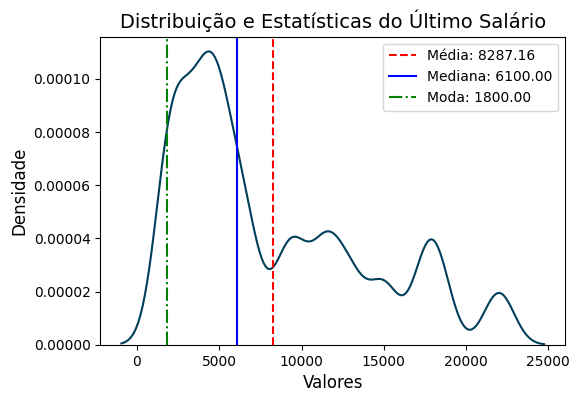

In [43]:
plot_config = {'figsize':(6, 4),
               'title':'Distribuição e Estatísticas do Último Salário',
               'x_label':'Valores',
               'y_label':'Densidade',
               'axis_font_size': 12,
               'title_size': 14,
               }
plot_displot_with_stats(df, 'ULTIMO_SALARIO', plot_config)

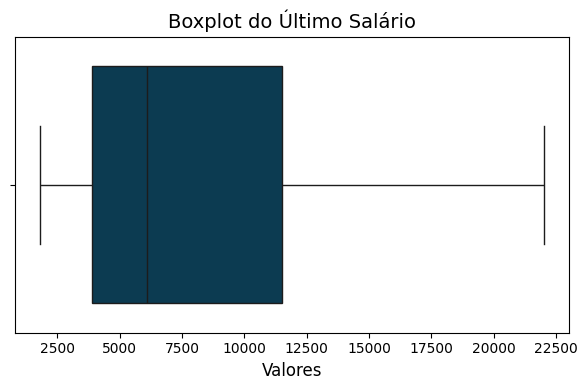

In [44]:
plot_config = {'figsize':(6, 4),
               'title':'Boxplot do Último Salário',
               'x_label':'Valores',
               'y_label':'',
               'axis_font_size': 12,
               'title_size': 14,
               }
plot_boxplot_simple(df, "ULTIMO_SALARIO", plot_config, orientation=False)


Como a distribuição dos dados satisfazem os seguintes requisitos:

    [x] é assimetrica
    [x] não contém outliers
    [x] não é categórica

Concluí-se que a média é o melhor valor para poder representar os dados faltantes.

In [45]:
df =  missing_input_by(df, 'ULTIMO_SALARIO', 'mean')
df['ULTIMO_SALARIO'].isnull().sum()

np.int64(0)

## General

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10476 entries, 0 to 10475
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CODIGO_CLIENTE              10476 non-null  int64  
 1   UF                          10476 non-null  object 
 2   IDADE                       10476 non-null  int64  
 3   ESCOLARIDADE                10476 non-null  object 
 4   ESTADO_CIVIL                10476 non-null  object 
 5   QT_FILHOS                   10476 non-null  int64  
 6   CASA_PROPRIA                10476 non-null  object 
 7   QT_IMOVEIS                  10476 non-null  int64  
 8   VL_IMOVEIS                  10476 non-null  int64  
 9   OUTRA_RENDA                 10476 non-null  object 
 10  OUTRA_RENDA_VALOR           10476 non-null  int64  
 11  TEMPO_ULTIMO_EMPREGO_MESES  10476 non-null  int64  
 12  TRABALHANDO_ATUALMENTE      10476 non-null  object 
 13  ULTIMO_SALARIO              104

## Estado

In [47]:
value_counts_with_percentage(df, 'UF').sort_values(by='Percentage', ascending=False)

,Count,Percentage
UF,,
RJ,2916,27.84
SP,2430,23.20
PR,1890,18.04
SC,1620,15.46
MG,1620,15.46


In [48]:
extended_stats_by_group(df, 'UF', 'SCORE')

,UF,Count,Min,Max,Mean,Median,StdDev,Skewness,IQR,Percentage,CoefVar
0,MG,1620,12.00,98.00,49.24,45.17,26.67,0.24,49.67,15.46,54.17
1,PR,1890,12.00,98.00,50.93,50.67,26.32,0.23,49.50,18.04,51.67
2,RJ,2916,12.00,98.00,53.13,50.67,27.79,0.25,49.50,27.84,52.30
3,SC,1620,12.00,98.00,47.98,47.92,26.66,0.25,55.17,15.46,55.57
4,SP,2430,12.00,98.00,51.95,45.17,28.07,0.23,44.00,23.20,54.04


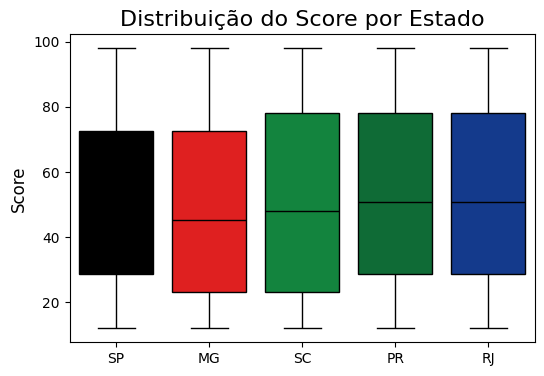

In [49]:
plot_config = {
    'figsize': (6, 4),
    'title': 'Distribuição do Score por Estado',
    'x_label': '',
    'y_label': 'Score',
    'axis_font_size': 12,
    'title_size': 16,
    'colors': {
        "RJ": {
            "primary_color": "#0033A0",
            "harmonized_color": "#0073E6"
        },
        "MG": {
            "primary_color": "#FF0000",
            "harmonized_color": "#FF6666"
        },
        "SC": {
            "primary_color": "#009739",
            "harmonized_color": "#66CC99"
        },
        "SP": {
            "primary_color": "#000000",
            "harmonized_color": "#595959"
        },
        "PR": {
            "primary_color": "#007A33",
            "harmonized_color": "#66B291"
        }
    }
}

plot_boxplot_grouped(df, 'SCORE', 'UF', plot_config)

## Idade

In [50]:
df.IDADE.describe()

count   10476.00
mean       41.05
std        13.88
min        19.00
25%        28.00
50%        42.00
75%        53.00
max        65.00
Name: IDADE, dtype: float64

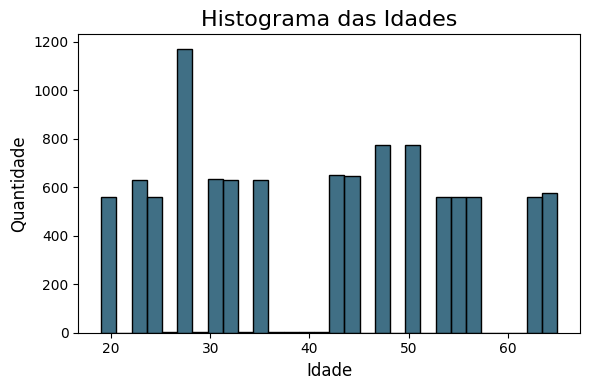

In [51]:
plot_config = {
    'figsize': (6, 4),
    'title': 'Histograma das Idades',
    'x_label': 'Idade',
    'y_label': 'Quantidade',
    'axis_font_size': 12,
    'title_size': 16 }

plot_histogram(df, 'IDADE', plot_config)

In [52]:
df.IDADE.nunique()

28

## Escolaridade

In [53]:
value_counts_with_percentage(df, "ESCOLARIDADE")

,Count,Percentage
ESCOLARIDADE,,
Superior Completo,3672,35.05
Superior Cursando,3654,34.88
Segundo Grau Completo,3150,30.07


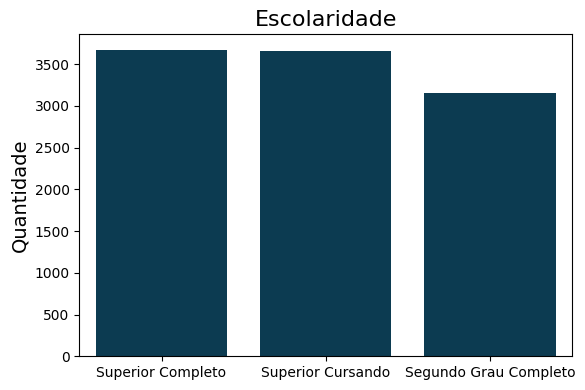

In [54]:
plot_config = {'figsize':(6, 4),
               'title':'Escolaridade',
               'x_label':'',
               'y_label':'Quantidade',
               'axis_font_size': 14,
               'title_size': 16
               }
plot_bar_simple(df, 'ESCOLARIDADE', plot_config, orientation='vertical' )

In [55]:
extended_stats_by_group(df, 'ESCOLARIDADE', 'SCORE')

,ESCOLARIDADE,Count,Min,Max,Mean,Median,StdDev,Skewness,IQR,Percentage,CoefVar
0,Segundo Grau Completo,3150,12.00,94.67,49.95,39.67,25.41,0.26,49.67,30.07,50.87
1,Superior Completo,3672,12.00,98.00,52.85,50.67,27.78,0.24,50.88,35.05,52.57
2,Superior Cursando,3654,12.00,98.00,50.22,45.17,28.30,0.23,49.50,34.88,56.36


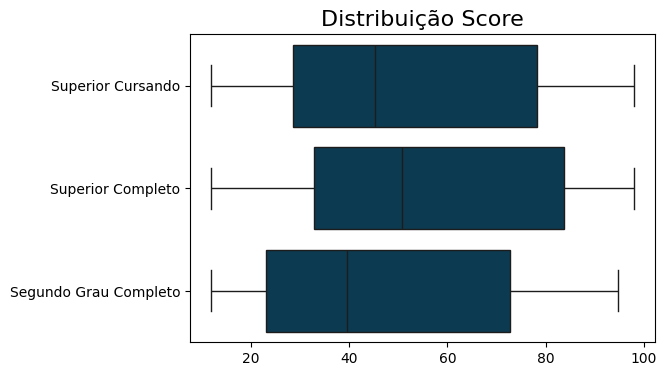

In [56]:
plot_config = {'figsize':(6, 4),
               'title':'Distribuição Score',
               'x_label':'',
               'y_label':'',
               'axis_font_size': 14,
               'title_size': 16
               }

plot_boxplot_grouped(df, 'SCORE','ESCOLARIDADE', plot_config, orientation='horizontal')

## Estado Civil

In [57]:
df['ESTADO_CIVIL'].describe()

count      10476
unique         4
top       Casado
freq        4716
Name: ESTADO_CIVIL, dtype: object

In [58]:
value_counts_with_percentage(df, 'ESTADO_CIVIL')

,Count,Percentage
ESTADO_CIVIL,,
Casado,4716,45.02
Solteiro,2592,24.74
Divorciado,2592,24.74
Viuvo,576,5.50


## Quantidade de Filhos

Observou-se uma suspeita de valores outliers na variável "QT_FILHOS"(quantidade de filhos), pois é incomum que um indivíduo tenha 42 filhos. A análise inicial indica dois valores que parecem candidatos a _outliers_.

Para confirmar se esses valores são realmente outliers, utilizaremos um boxplot. O boxplot permitirá visualizar a distribuição dos dados e identificar possíveis valores extremos que estão fora do intervalo esperado.

Após a análise com o boxplot, a suspeita foi confirmada: os valores identificados são, de fato, outliers.


---------------------------------------------------

**Como lidar com _outliers_ ?**

Existem várias maneiras de lidar com _outliers_, e muitas delas são semelhantes às técnicas utilizadas para imputação de dados ausentes (_missing data_). No entanto, é fundamental identificar estatisticamente quais valores devem ser considerados _outliers_ antes de realizar a substituição.

A identificação de _outliers_ pode ser feita por meio do Intervalo Interquartil (IQR), uma técnica baseada na estatística descritiva. O IQR mede a dispersão dos dados ao considerar a diferença entre o terceiro quartil (Q3) e o primeiro quartil (Q1), ou seja, a parte central de uma distribuição de dados. Valores que estão significativamente acima de Q3 ou abaixo de Q1 podem ser considerados outliers.

Após identificar esses valores extremos, podemos optar por substituí-los usando medidas de posição, como média, mediana ou moda. A escolha da medida adequada dependerá do comportamento dos dados e do objetivo da análise.

Neste caso, como a média, moda e mediana possuem seus valores muito próximos, substituiremos pela moda.
(ATENÇÃO: a média deu um valor decimal, atente-se ao utilizar a substituição por um valor inteiro, já que não há a possibilidade de obter 1 filho e meio, por exemplo.)

In [59]:
df['QT_FILHOS'].describe()

count   10476.00
mean        1.12
std         1.11
min         0.00
25%         0.00
50%         1.00
75%         2.00
max        42.00
Name: QT_FILHOS, dtype: float64

In [60]:
value_counts_with_percentage(df, 'QT_FILHOS')

,Count,Percentage
QT_FILHOS,,
1,3726,35.57
0,3329,31.78
2,2303,21.98
3,1116,10.65
38,1,0.01
42,1,0.01


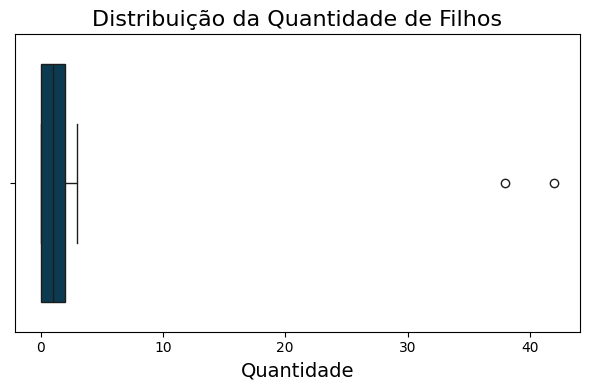

In [61]:
plot_config = {'figsize':(6, 4),
               'title':'Distribuição da Quantidade de Filhos',
               'x_label':'Quantidade',
               'y_label':'',
               'axis_font_size': 14,
               'title_size': 16
               }

plot_boxplot_simple(df, 'QT_FILHOS', plot_config)

In [62]:
print(f"Média: {df['QT_FILHOS'].mean():.2f}, Moda: {df['QT_FILHOS'].mode()[0]}, Mediana: {df['QT_FILHOS'].median()}")

Média: 1.12, Moda: 1, Mediana: 1.0


In [63]:
df['QT_FILHOS'] = replace_outliers(df, 'QT_FILHOS', 'mode')
df.QT_FILHOS.describe()

count   10476.00
mean        1.12
std         0.97
min         0.00
25%         0.00
50%         1.00
75%         2.00
max         3.00
Name: QT_FILHOS, dtype: float64

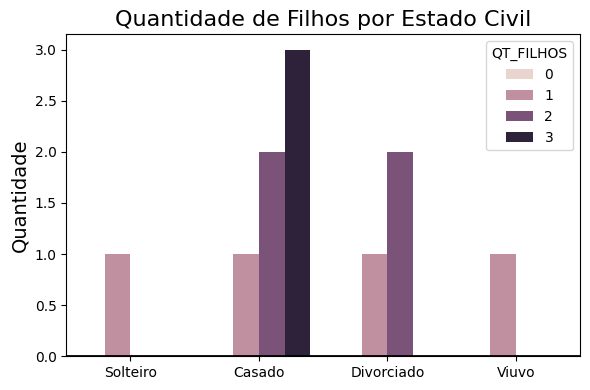

In [64]:
plot_config = {'figsize':(6, 4),
               'title':'Quantidade de Filhos por Estado Civil',
               'x_label':'',
               'y_label':'Quantidade',
               'axis_font_size': 14,
               'title_size': 16
               }

plot_bar_grouped(df, 'ESTADO_CIVIL', 'QT_FILHOS', plot_config, 'vertical')

## Casa Própria, Quantidade de Imóveis e Valor do Imóvel

Identificamos duas variáveis chave que podem estar correlacionadas: CASA_PROPRIA e QNT_IMOVEIS (quantidade de imóveis). É estratégico analisar essas variáveis em conjunto para garantir a consistência e a integridade dos dados.

Logicamente, se uma pessoa possui casa própria, o número de imóveis associados deve ser superior a zero. Por outro lado, se a pessoa não possui imóveis, essa variável deve ser zero. Qualquer desvio dessa lógica indica a possibilidade de inconsistências nos dados, o que pode impactar a qualidade da análise.

Em alguns casos, pode ser aceitável, pelas regras de negócio, que um indivíduo não tenha casa própria, mas possua outros imóveis. Essas exceções devem ser identificadas e comunicadas aos stakeholders relevantes para mitigar riscos e garantir a precisão das decisões baseadas nesses dados.

### Casa Própria

In [65]:
df.CASA_PROPRIA.describe()

count     10476
unique        2
top         Não
freq       5724
Name: CASA_PROPRIA, dtype: object

In [66]:
value_counts_with_percentage(df, 'CASA_PROPRIA')

,Count,Percentage
CASA_PROPRIA,,
Não,5724,54.64
Sim,4752,45.36


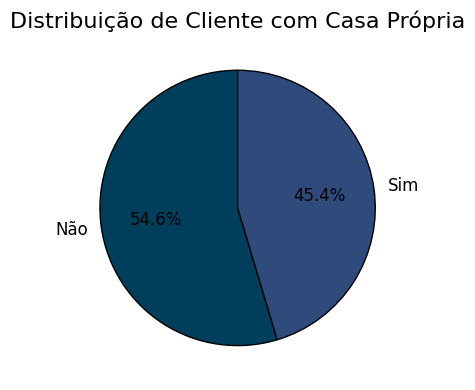

In [67]:
plot_config = {'figsize': (6, 4),
               'title': 'Distribuição de Cliente com Casa Própria',
               'text_size': 12,
               'title_size': 16,
              }

# Exemplo de uso
plot_pie_chart(df, 'CASA_PROPRIA', plot_config)

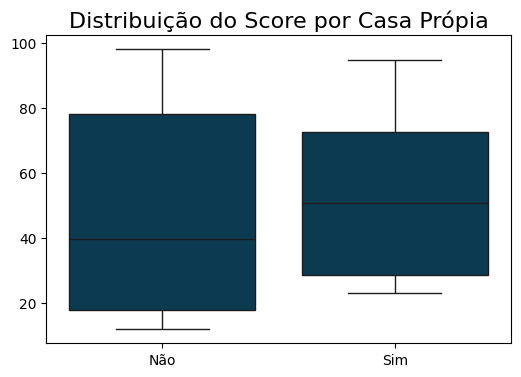

In [68]:
plot_config = {'figsize':(6, 4),
               'title':'Distribuição do Score por Casa Própia',
               'x_label':'',
               'y_label':'',
               'axis_font_size': 14,
               'title_size': 16
               }
plot_boxplot_grouped(df, 'SCORE', 'CASA_PROPRIA', plot_config)

### Qantidade de Imóveis

In [69]:
df['QT_IMOVEIS'].describe()

count   10476.00
mean        0.85
std         0.96
min         0.00
25%         0.00
50%         1.00
75%         1.00
max         3.00
Name: QT_IMOVEIS, dtype: float64

In [70]:
value_counts_with_percentage(df, 'QT_IMOVEIS')

,Count,Percentage
QT_IMOVEIS,,
0,4680,44.67
1,3762,35.91
3,1044,9.97
2,990,9.45


### Validação Casa Própria e Quantidade de Imóveis

In [71]:
# Validar o imovel prório e a quantidade de imóveis
try:
    # Validar o imóvel próprio e a quantidade de imóveis
    assert df[df['CASA_PROPRIA'] == 'Não'].shape[0] == df[df['QT_IMOVEIS'] == 0].shape[0], 'Provavelmente há um erro, neste caso o ideal é consultar as regras de negócio.'
except AssertionError as e:
    print(f"Erro de validação: {e}")

Erro de validação: Provavelmente há um erro, neste caso o ideal é consultar as regras de negócio.


### Valor dos Imóveis

Pela análise da distribuição dos dados, pode-se inferir que a variável Valor dos Imóveis provavelmente representa o valor total de todos os imóveis de uma pessoa, em vez do valor de um único imóvel.

Essa hipótese deve ser validada junto aos stakeholders, garantindo que o entendimento dos dados esteja alinhado com as regras de negócio e a realidade das transações imobiliárias.



In [72]:
df['VL_IMOVEIS'].describe()

count    10476.00
mean    238453.61
std     265843.93
min          0.00
25%          0.00
50%     185000.00
75%     370000.00
max     900000.00
Name: VL_IMOVEIS, dtype: float64

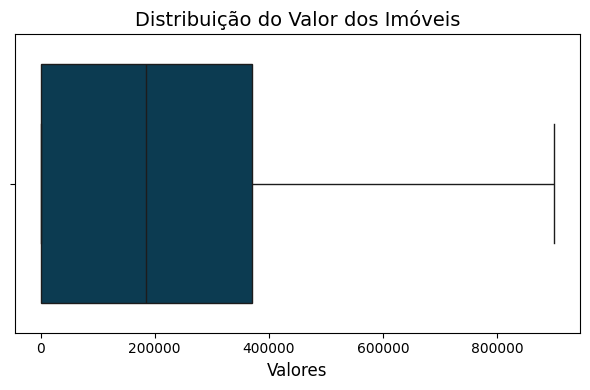

In [73]:
plot_config = {'figsize':(6, 4),
               'title':'Distribuição do Valor dos Imóveis',
               'x_label':'Valores',
               'y_label':'',
               'axis_font_size': 12,
               'title_size': 14,
               }
plot_boxplot_simple(df, 'VL_IMOVEIS', plot_config)

In [74]:
df[df['VL_IMOVEIS'] ==  900000 ].shape

(522, 19)

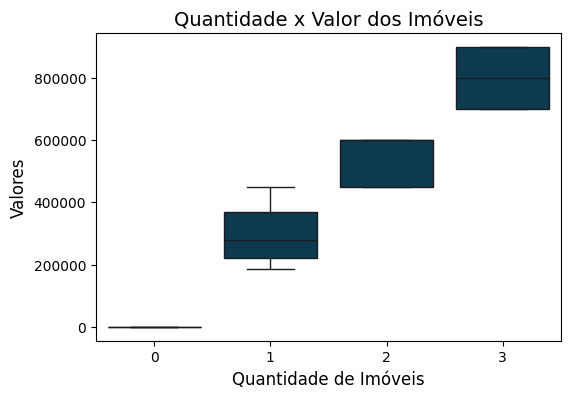

In [75]:
plot_config = {'figsize':(6, 4),
               'title': 'Quantidade x Valor dos Imóveis',
               'x_label':'Quantidade de Imóveis',
               'y_label':'Valores',
               'axis_font_size': 12,
               'title_size': 14,
               }
plot_boxplot_grouped(df, 'VL_IMOVEIS', 'QT_IMOVEIS', plot_config)

### Tratamento final do conjunto de atributos

A técnica de feature engineering também desempenha um papel fundamental na melhoria da análise, permitindo a extração de novas variáveis a partir da base de dados.

No caso das variáveis valor do imóvel e quantidade de imóveis, uma métrica relevante seria o valor médio por imóvel, especialmente em cenários onde uma pessoa possui mais de um imóvel. Essa abordagem oferece uma visão mais detalhada e pode melhorar a qualidade dos _insights_ gerados.

Além disso, a análise da importância relativa das variáveis pode ser fundamental. Se o valor total dos imóveis for altamente representativo, pode-se considerar duas abordagens: utilizar o valor total ou calcular a média por imóvel, assumindo que cada pessoa possui apenas um. Ambas as abordagens devem ser testadas para verificar o impacto nas análises e na performance do modelo.

Por fim, é essencial esclarecer se o valor do imóvel se refere ao total de todos os imóveis ou apenas a um deles. Essa distinção deve ser discutida com os _stakeholders_ para assegurar a correta interpretação dos dados e evitar distorções nas análises.

Entretanto, para essa análise vamos assumir uma coluna nova a VLM_IMOVEL que representará o valor médio dos imóveis. 

In [76]:
df['VLM_IMOVEIS'] = 0
df['VLM_IMOVEIS'] = df['VL_IMOVEIS'] / df['QT_IMOVEIS']
df.loc[ (df['QT_IMOVEIS'] == 0 ) & (df['VL_IMOVEIS'] == 0), 'VLM_IMOVEIS'] = 0
df['VLM_IMOVEIS'].describe(), df['VLM_IMOVEIS'].isnull().sum()

(count    10476.00
 mean    160303.55
 std     154963.89
 min          0.00
 25%          0.00
 50%     185000.00
 75%     300000.00
 max     450000.00
 Name: VLM_IMOVEIS, dtype: float64,
 np.int64(0))

## Renda

### Outra renda e Outra Renda Valor

As variáveis `OUTRA_RENDA` e `OUTRA_RENDA_VALOR`, podem ser utilizadas para verificar a consist~encia dos dados, uma vez que pela lógica o cliente que possui outra renda como sim, deveria ter o valor de `OUTRA_RENDA_VALOR` != 0. Essa validação é feita e os dados aparentemente são consistêntes. 

Inicialmente, foram identificados alguns _outliers_ nos valores da variável `OUTRA_RENDA_VALOR`. No entanto, esses valores são considerados plausíveis, uma vez que refletem a possibilidade de os indivíduos declararem uma renda adicional variável, e descrepante dos demais dependendo de suas fontes.

Dessa forma, optou-se por não remover ou substituir esses _outliers_, já que eles podem representar variações reais e importantes no perfil de renda. Essa decisão está alinhada com a premissa de manter a integridade dos dados para análises mais precisas, respeitando a realidade financeira dos declarantes.

> ** Atenção: ** Para fins de aplicação de algoritmos de Aprendizado de Máquina, pode ser que esses valores precisem ser suavizados para não enviesar os resultados. Tais aspectos serão discutidos quando necessário.

In [77]:
assert df[df['OUTRA_RENDA'] == 'Sim'].shape[0] == df[df['OUTRA_RENDA_VALOR'] != 0].shape[0], "Provavelmente há inconsitência"

In [78]:
df['OUTRA_RENDA'].value_counts()

OUTRA_RENDA
Não    8352
Sim    2124
Name: count, dtype: int64

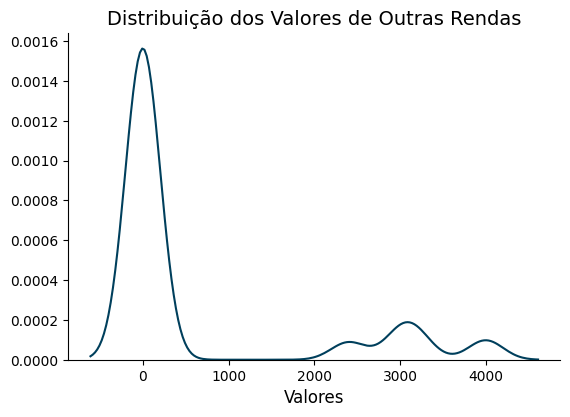

In [79]:
plot_config = {'figsize':(6, 4),
               'title':'Distribuição dos Valores de Outras Rendas',
               'x_label':'Valores',
               'y_label':'',
               'axis_font_size': 12,
               'title_size': 14,
               }
plot_displot_simple (df, 'OUTRA_RENDA_VALOR', plot_config) 

### Tempo de Emprego

Essa variável contém muitos valores diferentes são 17 no intervalo de [8:150].

Quando transformado em entrada para o Algoritmo de Aprendizado de Máquina, deve-se observar o impacto que essa variável terá ao passá-la para o algoritmo aplicando uma tecnica de discretização ou não em cima desses dados.

In [80]:
df['TEMPO_ULTIMO_EMPREGO_MESES'].nunique(), df['TEMPO_ULTIMO_EMPREGO_MESES'].describe(), 

(17,
 count   10476.00
 mean       43.07
 std        40.85
 min         8.00
 25%        14.00
 50%        22.00
 75%        75.00
 max       150.00
 Name: TEMPO_ULTIMO_EMPREGO_MESES, dtype: float64)

In [81]:
value_counts_with_percentage(df, 'TEMPO_ULTIMO_EMPREGO_MESES')

,Count,Percentage
TEMPO_ULTIMO_EMPREGO_MESES,,
8,846,8.08
9,792,7.56
18,792,7.56
22,792,7.56
30,792,7.56
14,792,7.56
19,612,5.84
80,522,4.98
15,522,4.98


### Último Salário e Trabalhando Atualmente

A variável TRABALHANDO_ATUALMENTE precisa ser validada em relação à variável ÚLTIMO_SALÁRIO, já que, se o cliente não está atualmente empregado, ele teoricamente não deveria ter uma renda salarial ativa. Nesse cenário, é necessário avaliar se faz sentido manter o valor do último salário ou aplicar outra lógica, conforme as regras de negócio.

Para os casos em que o cliente não está trabalhando, mas possui outra fonte de renda, é viável considerar a substituição do valor do último salário pelo valor de OUTRA_RENDA_VALOR. Além disso, faz sentido criar uma nova variável de RENDA_TOTAL? Desse modo que englobe todas as fontes de renda do cliente, garantindo uma visão mais completa de sua capacidade financeira.

Embora essa abordagem deve ser validada junto aos _stakeholders_ para assegurar que as regras de negócio sejam seguidas e que a análise de dados mantenha a precisão necessária, neste cenário, criaremos uma nova coluna representando a capacidade total de renda desses clientes : RENDA_TOTAL. 

Além disso, o cliente que não possuir salário, nem possuir uma outra fonte de renda, terá sua RENDA_TOTAL reprezentada por zero. 

In [82]:
value_counts_with_percentage(df, 'TRABALHANDO_ATUALMENTE')

,Count,Percentage
TRABALHANDO_ATUALMENTE,,
Sim,6336,60.48
Não,4140,39.52


In [83]:
df['ULTIMO_SALARIO'].describe()

count   10476.00
mean     8287.16
std      5826.47
min      1800.00
25%      3900.00
50%      6100.00
75%     11500.00
max     22000.00
Name: ULTIMO_SALARIO, dtype: float64

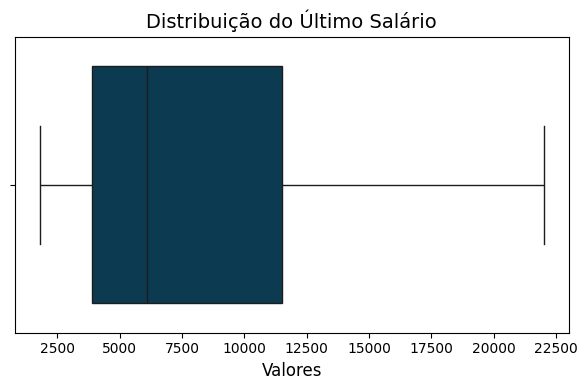

In [84]:
plot_config = {'figsize':(6, 4),
               'title':'Distribuição do Último Salário',
               'x_label':'Valores',
               'y_label':'',
               'axis_font_size': 12,
               'title_size': 14,
               }

plot_boxplot_simple(df, 'ULTIMO_SALARIO', plot_config)

In [85]:
# alguns não trabalham mas tem outra renda, esses podem passar?
df[(df['TRABALHANDO_ATUALMENTE'] == 'Não') & (df['OUTRA_RENDA_VALOR'] != 0)]['SCORE'].describe() 

count   522.00
mean     94.67
std       0.00
min      94.67
25%      94.67
50%      94.67
75%      94.67
max      94.67
Name: SCORE, dtype: float64

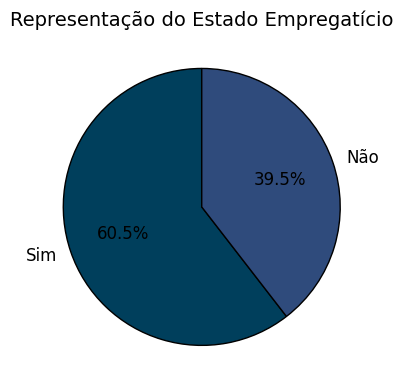

In [86]:
plot_config = {'figsize':(6, 4),
               'title':'Representação do Estado Empregatício',
               'x_label':'Valores',
               'y_label':'',
               'axis_font_size': 12,
               'title_size': 14,
               }
plot_pie_chart(df, 'TRABALHANDO_ATUALMENTE', plot_config)

In [87]:
df['OUTRA_RENDA'].value_counts()

OUTRA_RENDA
Não    8352
Sim    2124
Name: count, dtype: int64

### Último Salário

In [88]:
df['ULTIMO_SALARIO'].describe()

count   10476.00
mean     8287.16
std      5826.47
min      1800.00
25%      3900.00
50%      6100.00
75%     11500.00
max     22000.00
Name: ULTIMO_SALARIO, dtype: float64

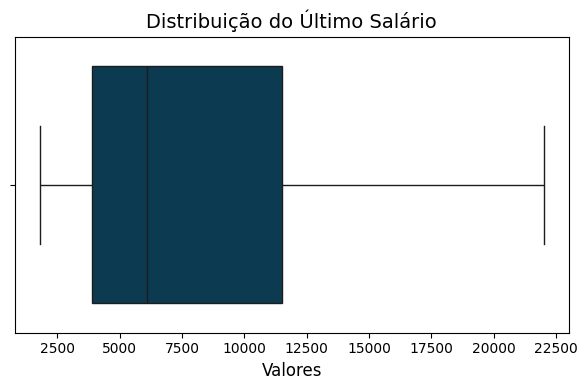

In [89]:
plot_config = {'figsize':(6, 4),
               'title':'Distribuição do Último Salário',
               'x_label':'Valores',
               'y_label':'',
               'axis_font_size': 12,
               'title_size': 14,
               }
plot_boxplot_simple(df, 'ULTIMO_SALARIO', plot_config)

## Renda Total

Por fim, foi criado uma nova variável a RENDA_TOTAL, que considera: 

* Cliente com outra renda e trabalhando:

    Se a pessoa possui outra renda e está trabalhando, a RENDA_TOTAL será a soma do último salário e o valor de outra renda.

* Cliente sem outra renda, mas trabalhando:

    Se a pessoa não possui outra renda, mas está trabalhando, a RENDA_TOTAL será o valor do último salário.

* Cliente não está trabalhando, mas possui outra renda:

    Se a pessoa não está trabalhando, mas possui outra renda, a RENDA_TOTAL será o valor de outra renda.


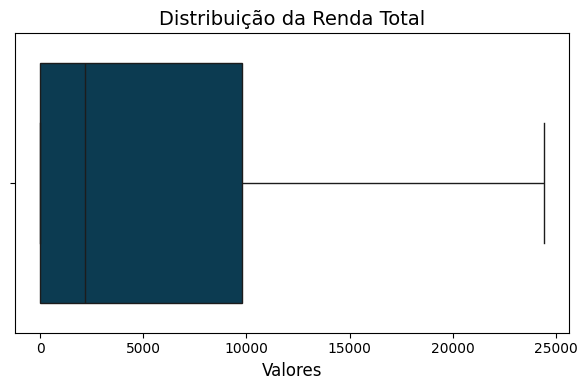

In [90]:
# Inicializa a coluna 'RENDA_TOTAL' com zero
df['RENDA_TOTAL'] = 0

# Se a pessoa possui outra renda e está trabalhando, soma a renda atual com a outra renda
df.loc[(df['OUTRA_RENDA'] == 'Sim') & (df['TRABALHANDO_ATUALMENTE'] == 'Sim'), 'RENDA_TOTAL'] = df['ULTIMO_SALARIO'] + df['OUTRA_RENDA_VALOR']

# Se a pessoa não possui outra renda e está trabalhando, a renda total é o último salário
df.loc[(df['OUTRA_RENDA'] == 'Não') & (df['TRABALHANDO_ATUALMENTE'] == 'Sim'), 'RENDA_TOTAL'] = df['ULTIMO_SALARIO'] 

# Se a pessoa não está trabalhando, mas possui outra renda, a renda total é o OUTRA_RENDA_VALOR
df.loc[(df['OUTRA_RENDA'] == 'Sim') & (df['TRABALHANDO_ATUALMENTE'] == 'Não'), 'RENDA_TOTAL'] =  df['OUTRA_RENDA_VALOR']

plot_config = {'figsize':(6, 4),
               'title':'Distribuição da Renda Total',
               'x_label':'Valores',
               'y_label':'',
               'axis_font_size': 12,
               'title_size': 14,
               }
plot_boxplot_simple(df, 'RENDA_TOTAL', plot_config)

###  Quantidade de Carros e Valor da Tabela

Para garantir a consistência dos dados, é possível realizar uma checagem entre as variáveis Quantidade de Carros e Valor Tabela Carros. A lógica esperada é a seguinte:

* Se o cliente não possui carros, o VALOR_TABELA_CARROS deve ser igual a zero.
* Para clientes que possuem carros, o VALOR_TABELA_CARROS deve ser maior que zero.

Essa verificação é importante para assegurar a integridade dos dados e garantir que a análise reflita corretamente a realidade dos clientes. Qualquer discrepância deve ser investigada e, se necessário, discutida com os _stakeholders_.

Além disso, criaremos uma coluna a VM_VEICULO, que representará o valor médio dos veículos.

In [91]:
df[ (df['QT_CARROS'] == 0) & (df['VALOR_TABELA_CARROS'] > 0)]

,CODIGO_CLIENTE,UF,IDADE,ESCOLARIDADE,ESTADO_CIVIL,QT_FILHOS,CASA_PROPRIA,QT_IMOVEIS,VL_IMOVEIS,OUTRA_RENDA,OUTRA_RENDA_VALOR,TEMPO_ULTIMO_EMPREGO_MESES,TRABALHANDO_ATUALMENTE,ULTIMO_SALARIO,QT_CARROS,VALOR_TABELA_CARROS,SCORE,SCORE_scaled,SCORE_classification,VLM_IMOVEIS,RENDA_TOTAL


In [92]:
df[ (df['QT_CARROS'] != 0) & (df['VALOR_TABELA_CARROS'] == 0)]

,CODIGO_CLIENTE,UF,IDADE,ESCOLARIDADE,ESTADO_CIVIL,QT_FILHOS,CASA_PROPRIA,QT_IMOVEIS,VL_IMOVEIS,OUTRA_RENDA,OUTRA_RENDA_VALOR,TEMPO_ULTIMO_EMPREGO_MESES,TRABALHANDO_ATUALMENTE,ULTIMO_SALARIO,QT_CARROS,VALOR_TABELA_CARROS,SCORE,SCORE_scaled,SCORE_classification,VLM_IMOVEIS,RENDA_TOTAL


In [93]:
value_counts_with_percentage(df, 'QT_CARROS') 

,Count,Percentage
QT_CARROS,,
0,3762,35.91
1,3618,34.54
2,3096,29.55


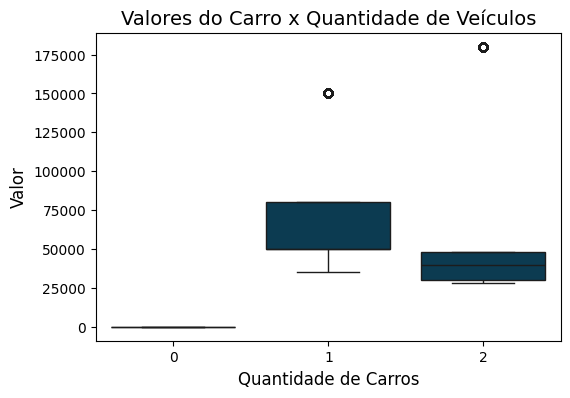

In [94]:
plot_config = {'figsize':(6, 4),
               'title':'Valores do Carro x Quantidade de Veículos',
               'x_label':'Quantidade de Carros',
               'y_label':'Valor',
               'axis_font_size': 12,
               'title_size': 14,
               }
plot_boxplot_grouped(df, 'VALOR_TABELA_CARROS', 'QT_CARROS', plot_config)

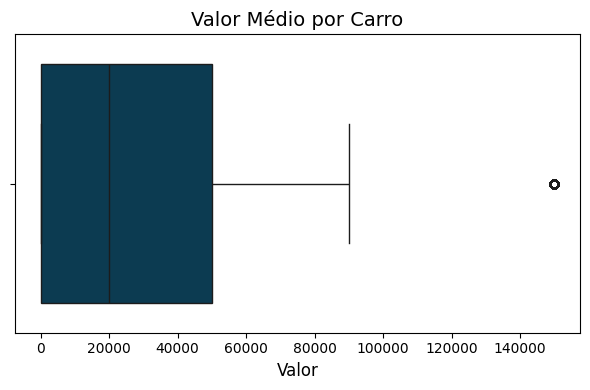

In [95]:
df['VM_VEICULOS'] = 0
df['VM_VEICULOS'] = df['VALOR_TABELA_CARROS'] / df['QT_CARROS']
df['VM_VEICULOS'] = df['VM_VEICULOS'].fillna(0)

plot_config = {'figsize':(6, 4),
               'title':'Valor Médio por Carro',
               'x_label':'Valor',
               'y_label':'',
               'axis_font_size': 12,
               'title_size': 14,
               }
plot_boxplot_simple(df, 'VM_VEICULOS', plot_config)

# Correlation Analysis

Filtrando Correlações Positivas


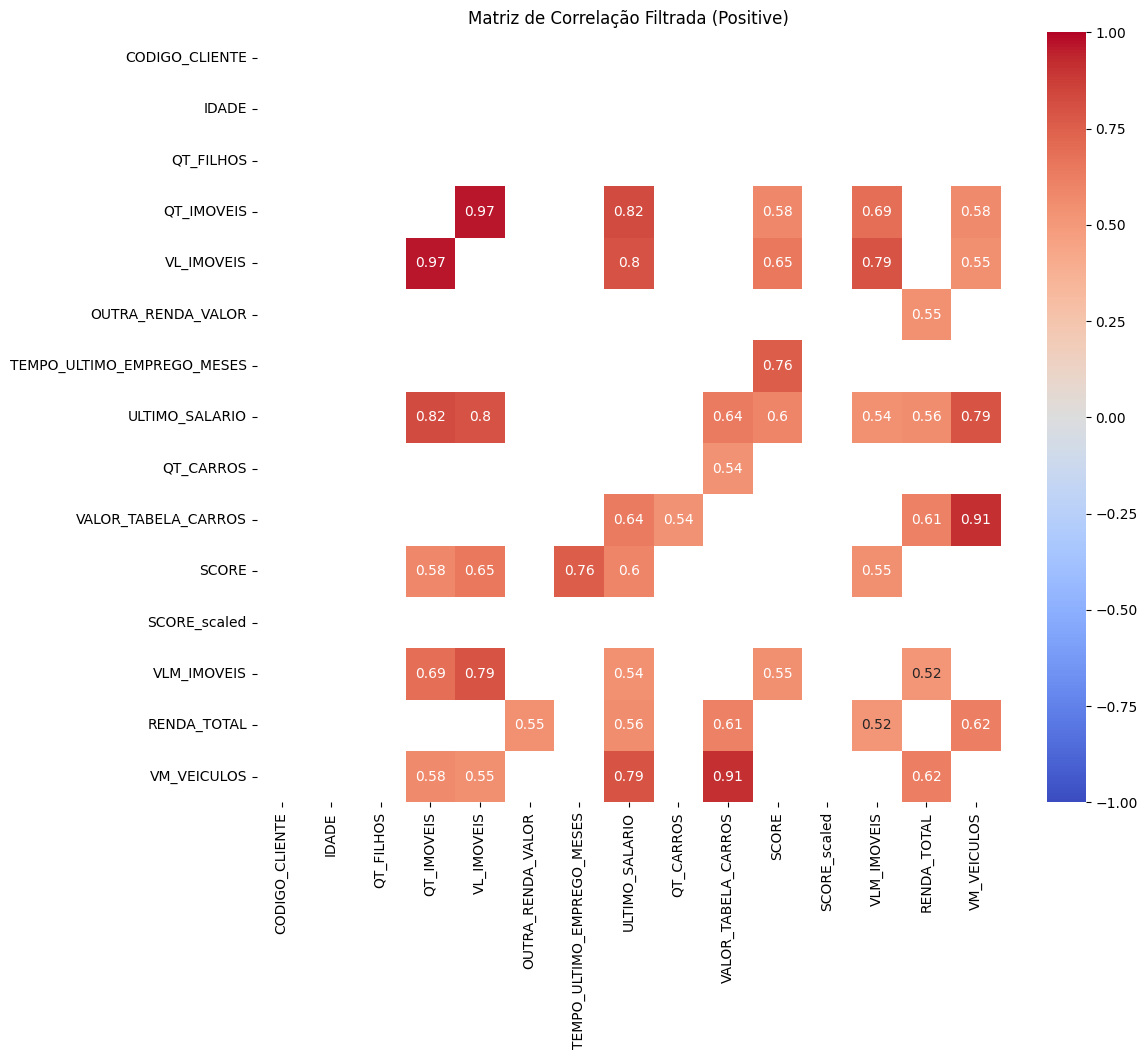

Filtrando Correlações Negativas


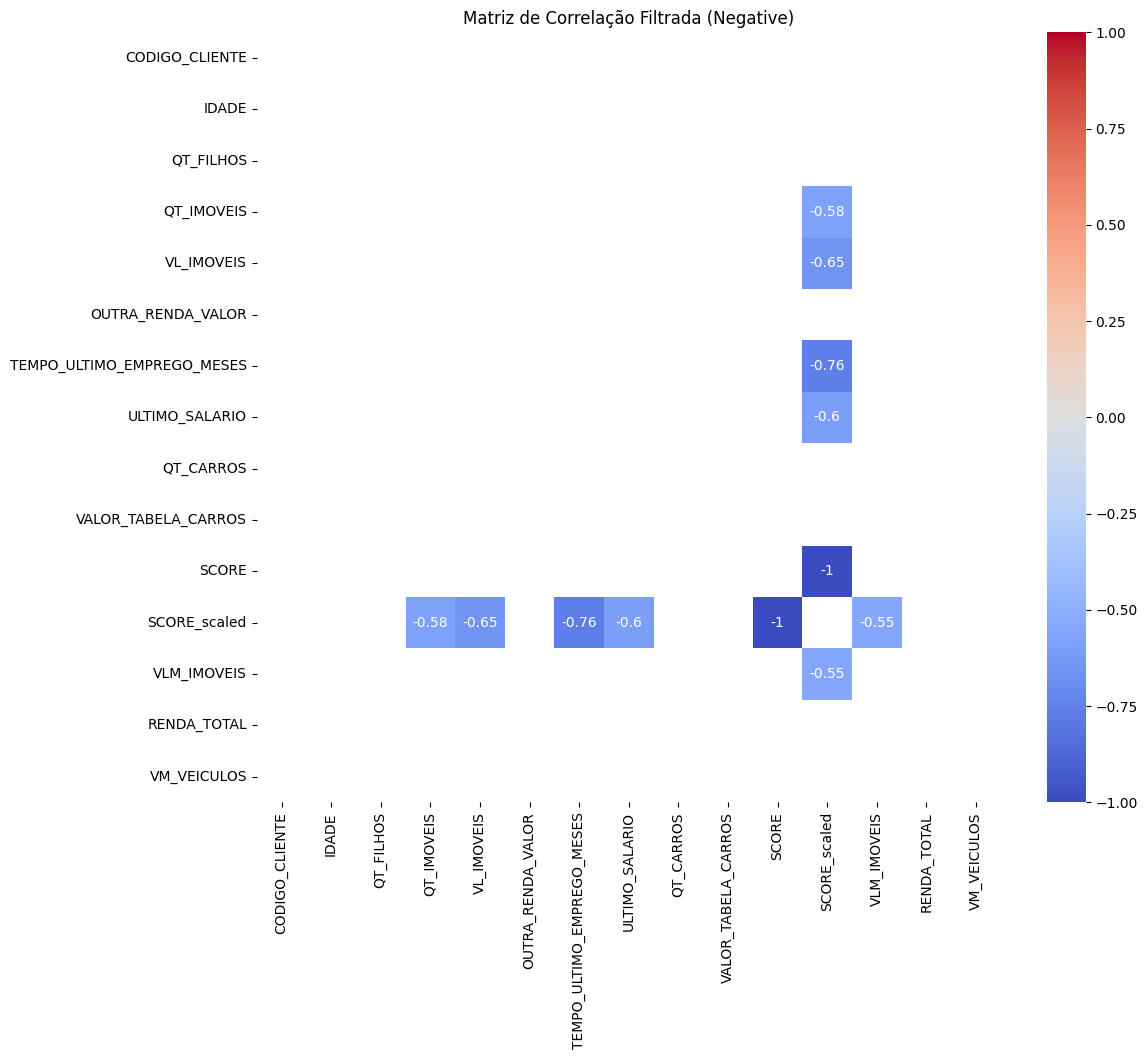

Filtrando Correlações Neutras


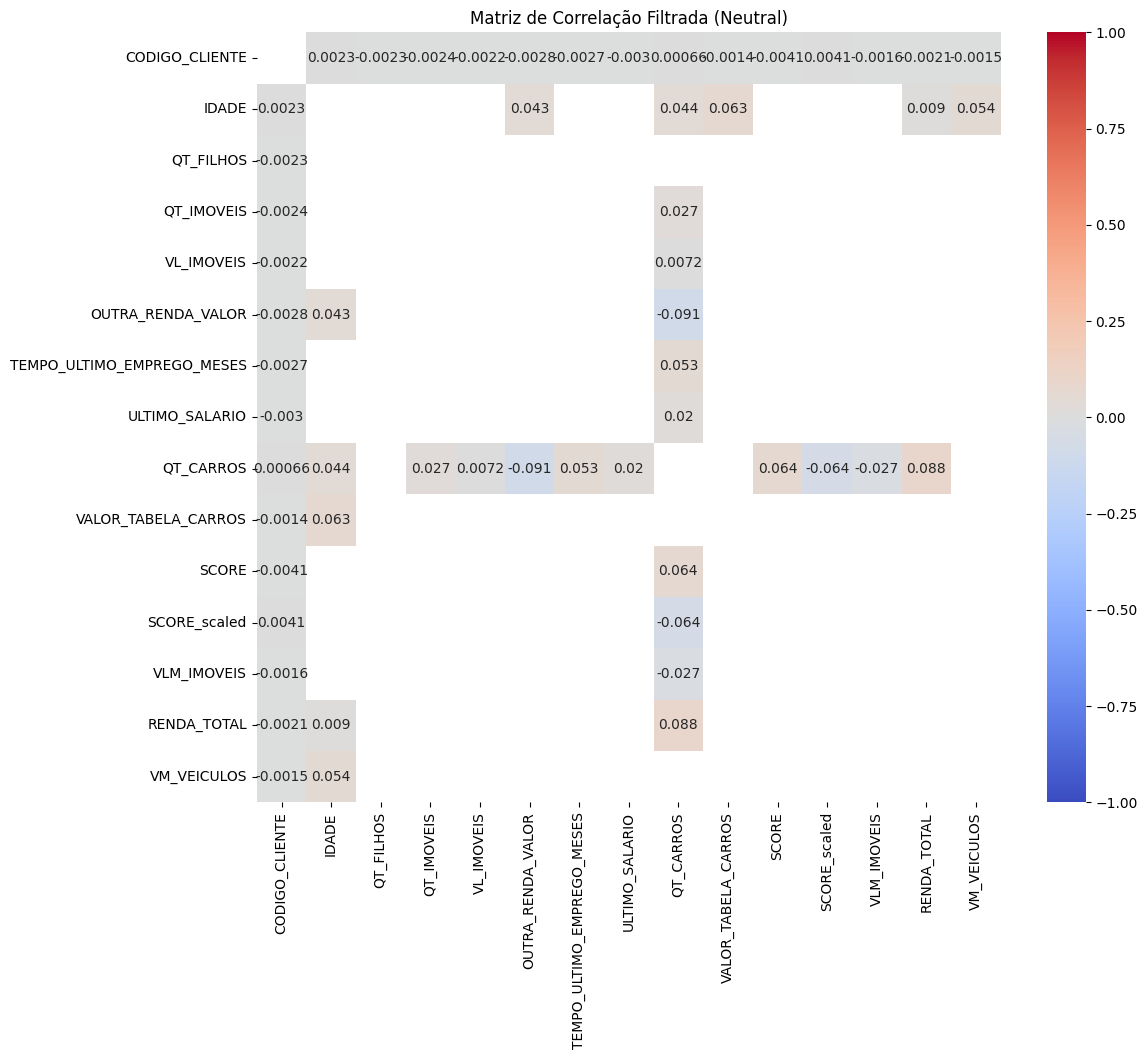

In [96]:
numeric_cols = df.select_dtypes(include=['int', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

plot_filtered_correlation_matrix(df[numeric_cols], 'positive')
plot_filtered_correlation_matrix(df[numeric_cols], 'negative')
plot_filtered_correlation_matrix(df[numeric_cols], 'neutral')

In [97]:
positive_correlations = get_correlations_with_target(df[numeric_cols], 'SCORE', 'positive')
positive_correlations

IDADE                        0.22
QT_FILHOS                    0.33
QT_IMOVEIS                   0.58
VL_IMOVEIS                   0.65
OUTRA_RENDA_VALOR            0.38
TEMPO_ULTIMO_EMPREGO_MESES   0.76
ULTIMO_SALARIO               0.60
QT_CARROS                    0.06
VALOR_TABELA_CARROS          0.35
VLM_IMOVEIS                  0.55
RENDA_TOTAL                  0.18
VM_VEICULOS                  0.29
Name: SCORE, dtype: float64

In [98]:
negative_correlations = get_correlations_with_target(df[numeric_cols], 'SCORE', 'negative')
negative_correlations

CODIGO_CLIENTE   -0.00
SCORE_scaled     -1.00
Name: SCORE, dtype: float64

In [99]:
neutral_correlations = get_correlations_with_target(df[numeric_cols], 'SCORE', 'neutral')
neutral_correlations

CODIGO_CLIENTE   -0.00
QT_CARROS         0.06
Name: SCORE, dtype: float64

In [100]:
positive_correlations.index.to_list()

['IDADE',
 'QT_FILHOS',
 'QT_IMOVEIS',
 'VL_IMOVEIS',
 'OUTRA_RENDA_VALOR',
 'TEMPO_ULTIMO_EMPREGO_MESES',
 'ULTIMO_SALARIO',
 'QT_CARROS',
 'VALOR_TABELA_CARROS',
 'VLM_IMOVEIS',
 'RENDA_TOTAL',
 'VM_VEICULOS']

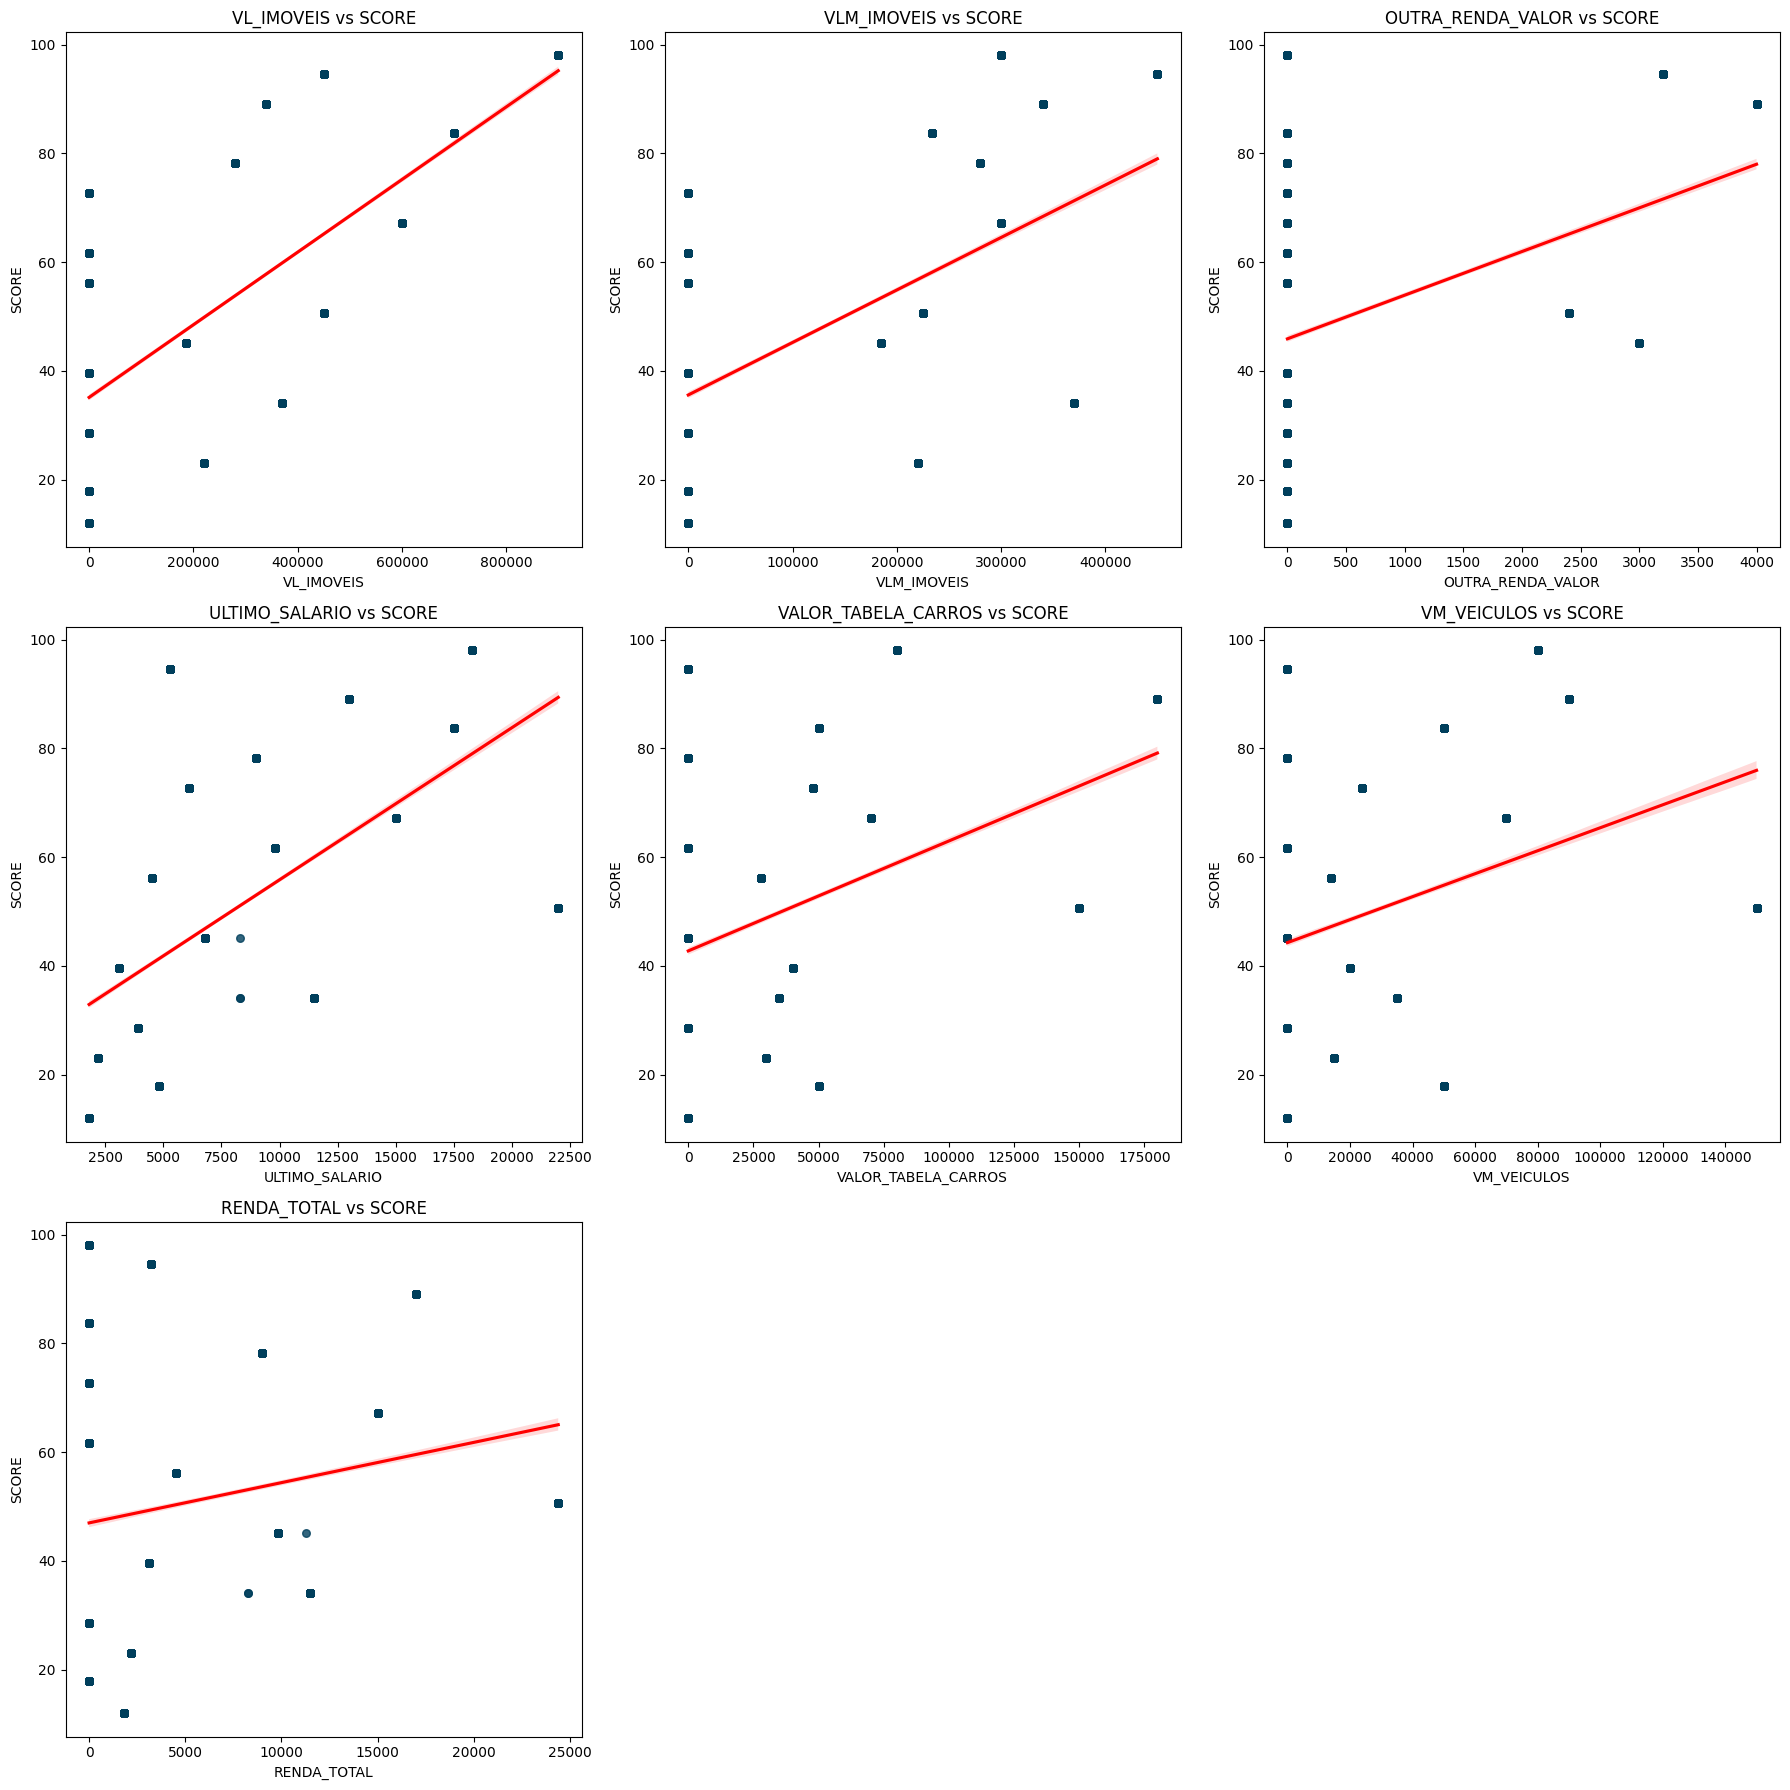

<Figure size 640x480 with 0 Axes>

In [101]:
plot_scatter_with_regression(df, 'SCORE', columns=['VL_IMOVEIS', 'VLM_IMOVEIS', 'OUTRA_RENDA_VALOR', 'ULTIMO_SALARIO', 'VALOR_TABELA_CARROS', 'VM_VEICULOS', 'RENDA_TOTAL'])

# Save Files

Após realizar as transformações e ajustes na base de dados original, é essencial salvar essas alterações para garantir que possamos utilizá-las posteriormente no processo de Aprendizado de Máquina.

In [104]:
df = df.set_index('CODIGO_CLIENTE')
df.to_csv('../datasets/dados_credito_pos_eda.csv', index=False)